In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import xgboost as xgb

from boruta import BorutaPy

from src import classes as c
from src import functions as f

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import plotly
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling_remixed.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

In [5]:
# creating f1 scorer
f1 = f.f1

In [6]:
modeling = c.Harness(f1)

## Creating the Baseline Dataframe

Dropping engineered features to establish the baseline score.

In [7]:
df.head(2)

,Target Remixed,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,...,Officer Squad,Frisk Flag,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,...,SOUTH PCT 1ST W - ROBERT,0,South,0,2015,10,16,4,11,1
1,0,NA,None,5670,1965,M,White,NA,NA,NA,...,NA,0,NA,0,2015,3,19,3,7,0


## Renaming the Target

In [8]:
df.rename(columns={'Target Remixed': 'Target'}, inplace=True)

In [9]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,...,Officer Squad,Frisk Flag,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,...,SOUTH PCT 1ST W - ROBERT,0,South,0,2015,10,16,4,11,1
1,0,NA,None,5670,1965,M,White,NA,NA,NA,...,NA,0,NA,0,2015,3,19,3,7,0


## Excluding Extraneous Features

In [10]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [11]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

## Baseline Data Frame

In [12]:
baseline_df = f.framer(df, [], excluded)

In [13]:
baseline_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
1,0,NA,None,1965,M,White,NA,NA,NA,NA,NA,NA


In [14]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Weapon Type               46960 non-null  object
 3   Officer YOB               46960 non-null  int64 
 4   Officer Gender            46960 non-null  object
 5   Officer Race              46960 non-null  object
 6   Subject Perceived Race    46960 non-null  object
 7   Subject Perceived Gender  46960 non-null  object
 8   Initial Call Type         46960 non-null  object
 9   Call Type                 46960 non-null  object
 10  Officer Squad             46960 non-null  object
 11  Precinct                  46960 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.3+ MB


## Creating X, y & Train Test Split

In [15]:
X, y = f.Xy(baseline_df)

In [16]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression

## Creating Pipeline

In [17]:
# adding a random state for a future solver gridsearch 
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [18]:
baseline = make_pipeline(preprocessing_mm, LR)

## Fitting & Scoring Model

In [19]:
baseline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa901e7a730>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa901e7a670>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [20]:
#scoring the model
f1_score(y_train, baseline.predict(X_train))

0.884196120994762

## Cross Val Scores

In [21]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'LR Baseline', 'Log Reg, min/max')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline has an average F1 of 0.8810525054191466


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


array([0.88269208, 0.88256816, 0.88164422, 0.88122696, 0.8771311 ])

## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


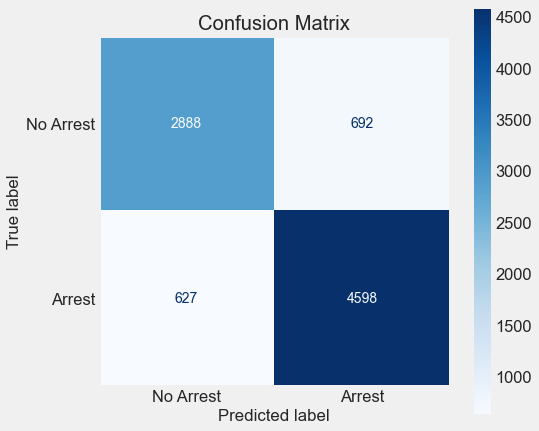

,Train F1,Test F1
0,0.885469,0.87456


In [22]:
f.subsplit_test(X_train, y_train, baseline)

## Baseline Score: F1 = 0.87456

## Baseline Coefficients & Odds

In [34]:
coeff = baseline[1].coef_.flatten()

In [35]:
features = list(baseline[0].transformers_[0][1].get_feature_names()) +\
                list(X_train.select_dtypes('number').columns)

In [36]:
coefficients = pd.DataFrame(coeff, features, columns=['coef'])\
                            .sort_values(by='coef', ascending=False)

In [38]:
top20_pos_coef = coefficients.head(20)

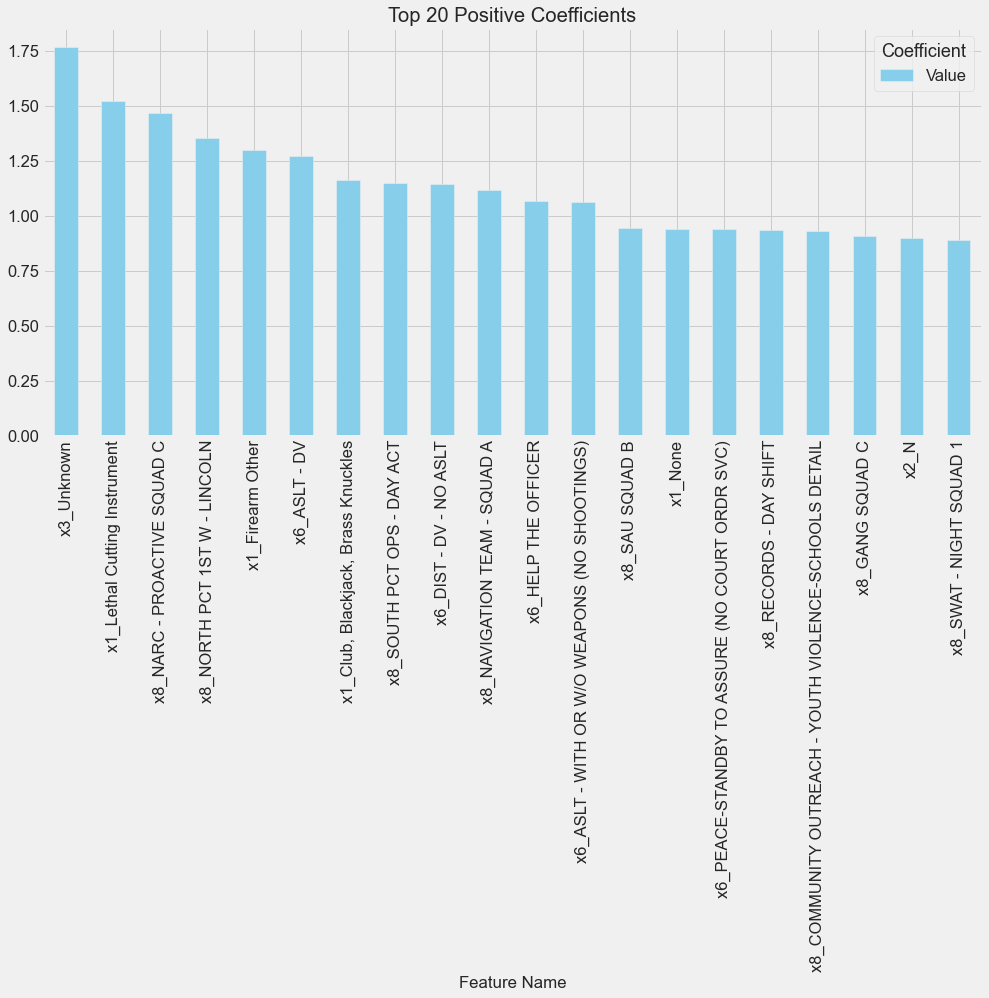

In [39]:
top20_pos_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Positive Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [40]:
top20_neg_coef = coefficients.tail(20)

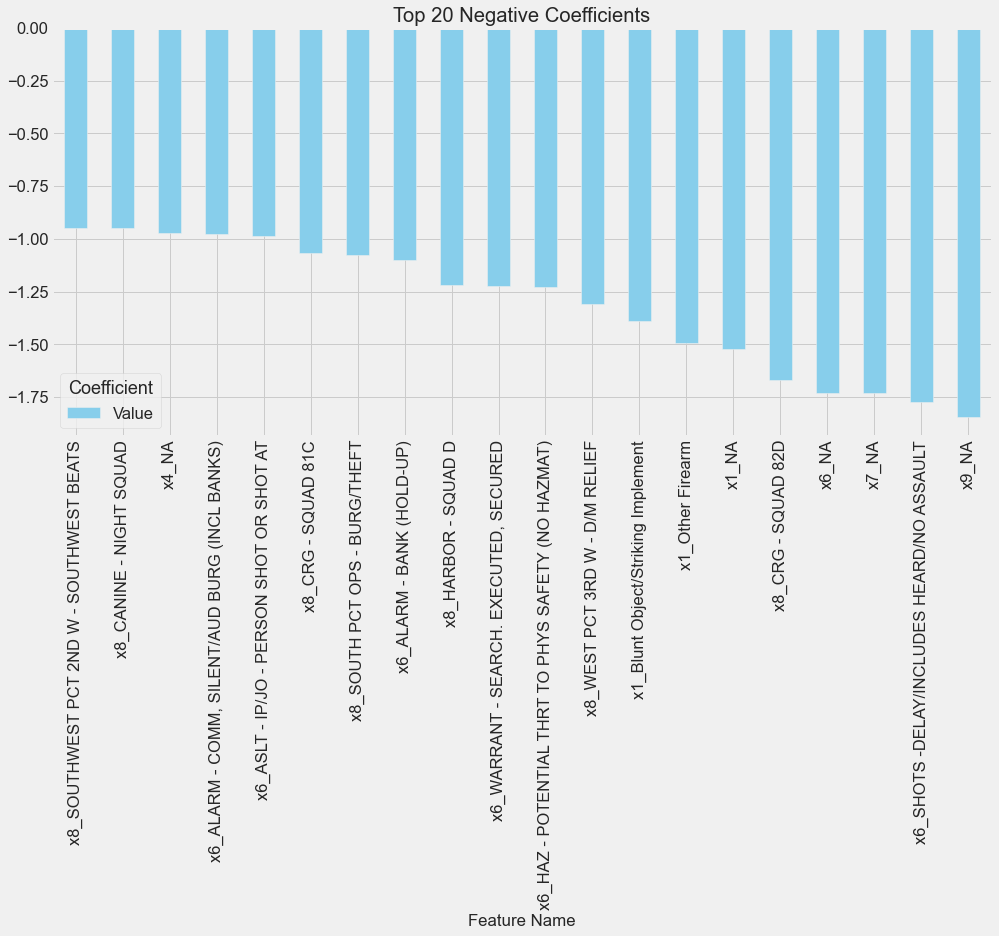

In [41]:
top20_neg_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Negative Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [42]:
odds = np.exp(coeff)
odds_df = pd.DataFrame(odds, 
             features, 
             columns=['odds'])\
            .sort_values(by='odds', ascending=False)

In [43]:
top20_pos_odds = odds_df.head(20).reset_index()

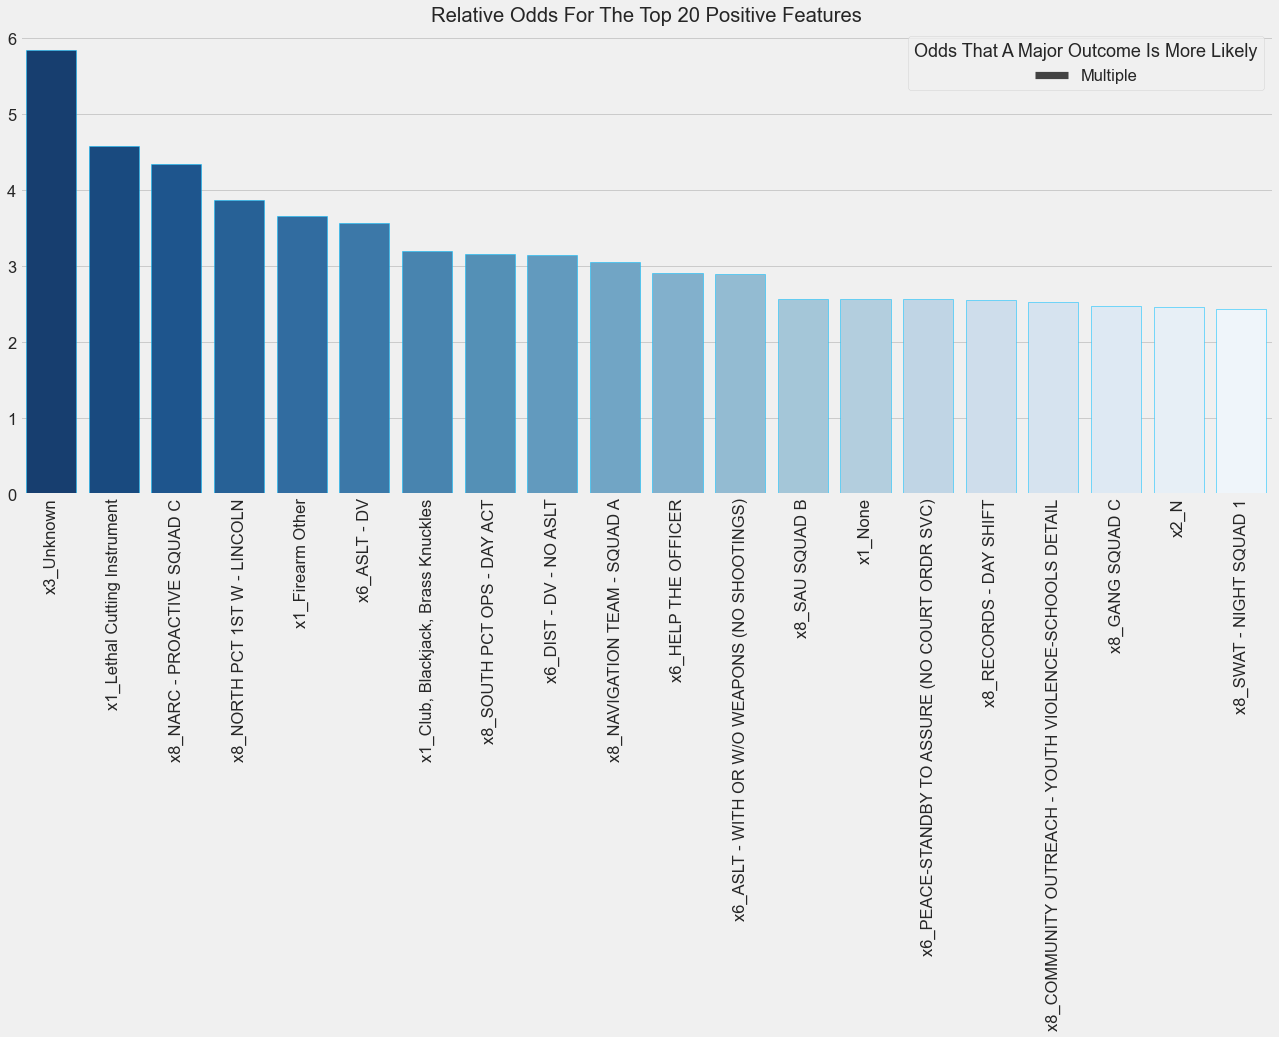

In [50]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_pos_odds, palette='Blues_r', edgecolor='deepskyblue')
plt.title('Relative Odds For The Top 20 Positive Features')                                                 
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Major Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('Baseline_Positive',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

In [45]:
top20_neg_odds = odds_df.tail(20).reset_index()

In [46]:
top20_neg_odds['odds'] = 1/top20_neg_odds['odds']

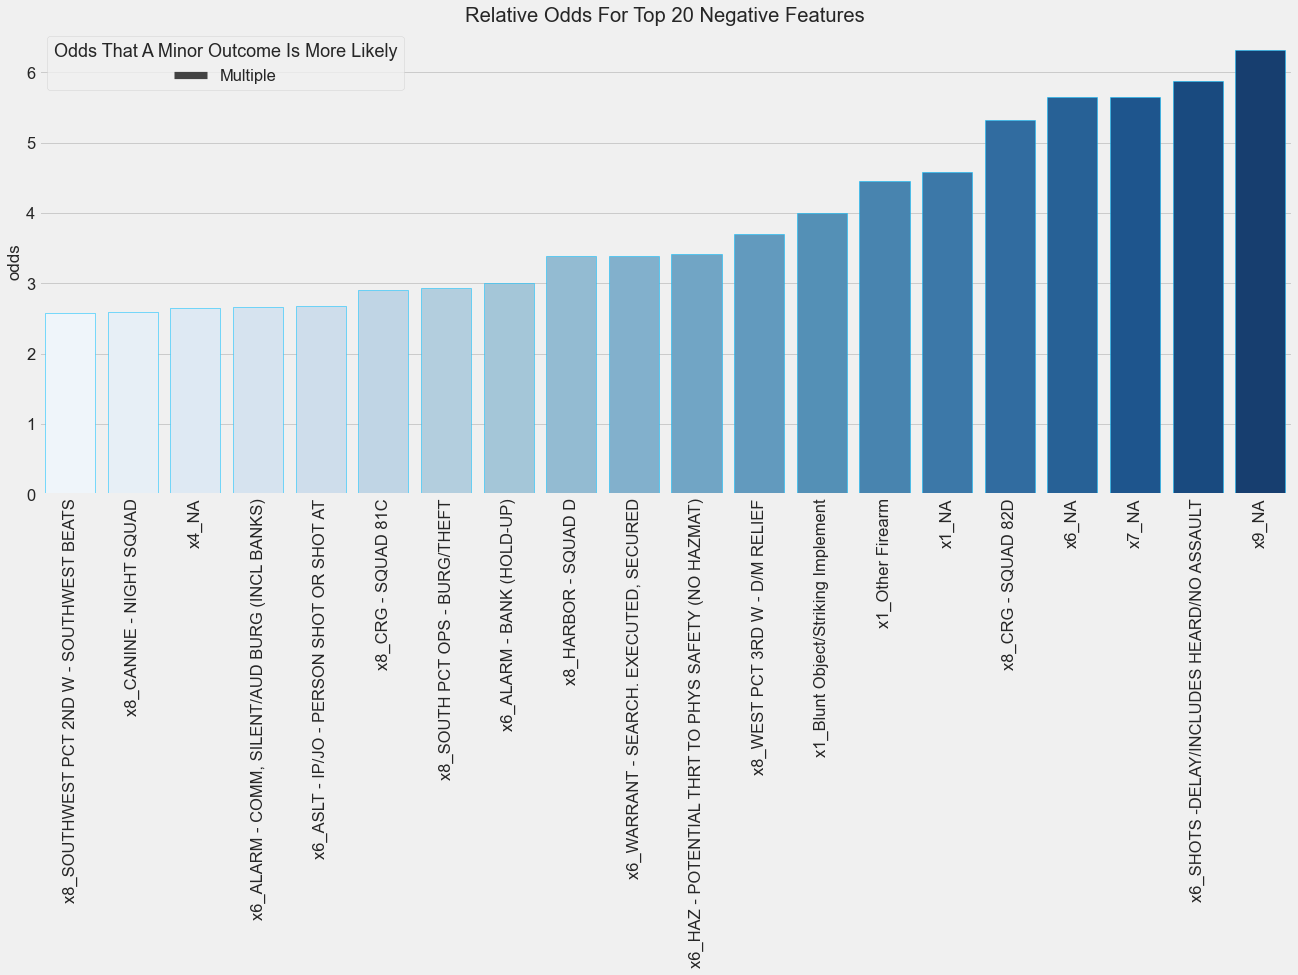

In [51]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_neg_odds, palette='Blues', edgecolor='deepskyblue')
plt.title('Relative Odds For Top 20 Negative Features')                                                 
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Minor Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('Baseline_Negative',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

In [49]:
baseline_df.columns

Index(['Target', 'Subject Age Group', 'Weapon Type', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Initial Call Type', 'Call Type',
       'Officer Squad', 'Precinct'],
      dtype='object')

In [48]:
features 

['x0_1 - 17',
 'x0_18 - 25',
 'x0_26 - 35',
 'x0_36 - 45',
 'x0_46 - 55',
 'x0_56 and Above',
 'x0_NA',
 'x1_Automatic Handgun',
 'x1_Blackjack',
 'x1_Blunt Object/Striking Implement',
 'x1_Brass Knuckles',
 'x1_Club',
 'x1_Club, Blackjack, Brass Knuckles',
 'x1_Fire/Incendiary Device',
 'x1_Firearm',
 'x1_Firearm (unk type)',
 'x1_Firearm Other',
 'x1_Handgun',
 'x1_Knife/Cutting/Stabbing Instrument',
 'x1_Lethal Cutting Instrument',
 'x1_Mace/Pepper Spray',
 'x1_NA',
 'x1_None',
 'x1_None/Not Applicable',
 'x1_Other Firearm',
 'x1_Personal Weapons (hands, feet, etc.)',
 'x1_Rifle',
 'x1_Shotgun',
 'x1_Taser/Stun Gun',
 'x2_F',
 'x2_M',
 'x2_N',
 'x3_Asian',
 'x3_Black',
 'x3_Hispanic',
 'x3_Multi-Racial',
 'x3_NA',
 'x3_N_American',
 'x3_P_Islander',
 'x3_Unknown',
 'x3_White',
 'x4_Asian',
 'x4_Black',
 'x4_Hispanic',
 'x4_Multi-Racial',
 'x4_NA',
 'x4_N_American',
 'x4_Other',
 'x4_P_Islander',
 'x4_Unknown',
 'x4_White',
 'x5_Female',
 'x5_Gender Diverse',
 'x5_Male',
 'x5_NA',
 '

## Baseline Logistic Regression w/smote

## Pipeline

In [ ]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [ ]:
baseline_smote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR Baseline SMOTE', 'Log Reg min/max')

In [ ]:
modeling.history

## Sub-Splitting the Training Data

In [ ]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Baseline LR w/SMOTE Score: F1 = 0.868125

## Feature Engineering

## Dropping Subject and Officer Race Nulls

In [ ]:
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

## Creating New Data Frame w/Dropped Nulls

In [ ]:
dropped_df = f.framer(df, [], excluded)

In [ ]:
dropped_df.head(2)

## New Test Train Split

In [ ]:
X, y = f.Xy(dropped_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression w/o SMOTE on Dropped Nulls Data

## Pipeline

In [ ]:
baseline_nosmote = make_pipeline(preprocessing_mm, LR)

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'LR, Dropped Nulls')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR No SMOTE on Dropped Nulls Score: 0.890325

## Baseline Logistic Regression w/SMOTE on Dropped Nulls Data

## Pipeline

In [ ]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [ ]:
baseline_smote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'LR, Dropped Nulls')

In [ ]:
modeling.history

## Sub-Splitting the Training Data

In [ ]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR w/SMOTE on Dropped Nulls Data Score: F1=0.879422

## Investigating the Data More Closely
Looking for some score improvement through feature engineering 

In [ ]:
cols = baseline_df.columns
for col in cols:
    print(f'{df[col].value_counts()}\n')

In [ ]:
baseline_df['Officer YOB'].describe()

## Creating & Testing Officer Age Feature
Creating `Officer Age` feature, dropping invalid ages and `Officer YOB` feature.

In [ ]:
df['Officer Age'] = df['Reported Year'] - df['Officer YOB']
df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(subset = ['Officer Age'], inplace=True)

In [ ]:
df.drop('Officer YOB', axis=1, inplace=True)

## New Data Frame

In [ ]:
age_df = f.framer(df, [], excluded)

In [ ]:
age_df.head(2)

In [ ]:
age_df.info()

## New Test Train Split

In [ ]:
X, y = f.Xy(age_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Baseline LR on New Data

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, officer age')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR w/Officer Age Score: F1=0.878195

## Creating Racial Affinity Feature
0 if subject and officer are different races; 1 if subject and officer are different races.

In [ ]:
df['Racial Affinity'] = [1 if df['Subject Perceived Race'][row]\
                         == df['Officer Race'][row] else 0 for row in df.index]

In [ ]:
df.head(3)

## New Data Frame

In [ ]:
# excluding Officer ID, 'Final Call Type', and Frisk Flag
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age']

In [ ]:
RA_df = f.framer(df, [], excluded)

In [ ]:
RA_df.head(2)

In [ ]:
X, y = f.Xy(RA_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Racial Affinity Feature

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, racial affinity')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Racial Affinity Score: F1=0.884281

## Gender Affinity Feature
0 if subject and officer are different genders; 1 if the same.

In [ ]:
df['Officer Gender'].value_counts()

In [ ]:
df['Officer Gender'] = df['Officer Gender'].apply(lambda x: 'Male' if x=='M' else 'Female')

In [ ]:
df['Gender Affinity'] = [1 if df['Subject Perceived Gender'][row]\
                         == df['Officer Gender'][row] else 0 for row in df.index]

In [ ]:
df.head(2)

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity']

In [ ]:
GA_df = f.framer(df, [], excluded)

In [ ]:
GA_df.head(2)

In [ ]:
X, y = f.Xy(GA_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Gender Affinity

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, gender affinity')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Gender Affinity Score: F1=0.884676

## Binning Weapon Type
Binning into NONE, GUN, KNIFE, OTHER

In [ ]:
# checking weapon types
df['Weapon Type'].unique()

In [ ]:
NONE= ['None', 'NA','None/Not Applicable']

GUN = ['Firearm Other', 'Handgun', 'Other Firearm',
        'Rifle', 'Firearm (unk type)', 'Firearm',
        'Shotgun', 'Automatic Handgun']

KNIFE = ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']

OTHER = ['Club, Blackjack, Brass Knuckles',
         'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
         'Mace/Pepper Spray', 'Club', 'Taser/Stun Gun',
         'Brass Knuckles','Blackjack',
         'Personal Weapons (hands, feet, etc.)']

In [ ]:
df['Weapon Bins'] = df['Weapon Type'].copy()

In [ ]:
df['Weapon Bins']

In [ ]:
for type in NONE:
    df['Weapon Bins'].replace(type, 'NONE', inplace=True)
for type in GUN:
    df['Weapon Bins'].replace(type, 'GUN', inplace=True)
for type in KNIFE:
    df['Weapon Bins'].replace(type, 'KNIFE', inplace=True)
for type in OTHER:
    df['Weapon Bins'].replace(type, 'OTHER', inplace=True)

In [ ]:
df['Weapon Bins'].value_counts(normalize=True)

## 94% of Subjects Are Unarmed and Only 1% Have a Gun.

In [ ]:
df.head(2)

## New Data Frame w/Weapons Bins

In [ ]:
excluded = ['Weapon Type', 'Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity']

In [ ]:
WB_df = f.framer(df, [], excluded)

In [ ]:
WB_df.head(2)

In [ ]:
X, y = f.Xy(WB_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Weapon Bins

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, weapon bins')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Weapon Bins Score: F1=0.875523

## Testing Weapon Flag
The weapon flag binary (0 = no weapon) has been excluded from tests up to this point.

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Type', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins']

In [ ]:
WF_df = f.framer(df, [], excluded)

In [ ]:
WF_df.head(2)

In [ ]:
X, y = f.Xy(WF_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Weapon Flag

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, weapon flag')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Weapon Flag Score: F1=0.875167

## Binarizing Initial Call Type
0 = no call information provided.

In [ ]:
df['Initial Call Bin'] = df['Initial Call Type'].copy()

In [ ]:
df['Initial Call Bin'] = df['Initial Call Bin'].replace('NA', 0)
df['Initial Call Bin'] = df['Initial Call Bin'].map(lambda x: 1 if x!=0 else 0)

In [ ]:
df['Initial Call Bin'].value_counts()

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 'Initial Call Type']

In [ ]:
ICB_df = f.framer(df, [], excluded)

In [ ]:
ICB_df.head(2)

In [ ]:
X, y = f.Xy(ICB_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Initial Call Type Binary

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, Initial Call Binary')

In [ ]:
modeling.history

## Subsplit Test

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Initial Call Types Binary Score: F1=0.8793

## Binning Call Types
Binning into 911, OTHER, ONVIEW.

In [ ]:
types = df['Call Type'].unique()

In [ ]:
replace_list = [x for x in types if (x!='911') and (x!='ONVIEW')]

In [ ]:
df['Call Type Bins'] = df['Call Type'].copy()

In [ ]:
df['Call Type Bins'] = df['Call Type Bins'].replace(replace_list, 'OTHER')

In [ ]:
df['Call Type Bins'].value_counts(normalize=True)

In [ ]:
df.info()

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type']

In [ ]:
BCT_df = f.framer(df, [], excluded)

In [ ]:
BCT_df.head(2)

In [ ]:
X, y = f.Xy(BCT_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Call Type Bins

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE ', 'Dropped Nulls, call type bins')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Call Type Bins Score: F1=0.884391

## Binning the Squad Data
The squads look like they can be binned into precinct goups, a training group and an group of smaller precincts. 

In [ ]:
df['Officer Squad Bins'] = df['Officer Squad'].copy()

In [ ]:
df['Officer Squad Bins'] = df['Officer Squad Bins'].map(lambda x: x[0])

In [ ]:
df['Officer Squad Bins'].value_counts(normalize=True)

In [ ]:
proportions = df['Officer Squad Bins'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .02].index
for i in cutoff_idx:
    df['Officer Squad Bins'].replace(i, 'OTHER', inplace=True)

In [ ]:
df['Officer Squad Bins'].value_counts()

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad']

In [ ]:
BSQ_df = f.framer(df, [], excluded)

In [ ]:
BSQ_df.head(2)

In [ ]:
X, y = f.Xy(BSQ_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Precinct Bins

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, Squad Bins')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Precinct Bins Score: F1=0.883155

## Binarizing Officer Race
Binarizing into White and Non-White.

In [ ]:
df['Officer Race Bins'] = df['Officer Race'].copy()

In [ ]:
df['Officer Race Bins'].replace('White', 1, inplace=True)

In [ ]:
df['Officer Race Bins'] = df['Officer Race Bins'].apply(lambda x: 0 if x!=1 else 1)

In [ ]:
df['Officer Race Bins'].value_counts()

In [ ]:
df['Officer Race Bins'].value_counts(normalize=True)

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins',
            'Officer Race']

In [ ]:
ORB_df = f.framer(df, [], excluded)

In [ ]:
ORB_df.head(2)

In [ ]:
X, y = f.Xy(ORB_df)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Officer Race Binary

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train, 'LR w/o SMOTE', 'Dropped Nulls, Officer Race Bins')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR w/Officer Race Binary Score: F1=0.885071

## Testing on Top Features w/o Time
Test LR with features that perfomed better than the baseline features.

## New Data Frame

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Weapon Bins', 'Officer Race',
            'Initial Call Bin']

In [ ]:
df_6 = f.framer(df, [], excluded)

In [ ]:
df_6.head(2)

In [ ]:
df_6.info()

In [ ]:
X, y = f.Xy(df_6)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'Top Features w/o Time, Dropped Nulls')

In [ ]:
modeling.history

## Testing on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR Top Features w/o Time Score: F1=0.884919

## Testing on All Features w/o Time

## New Data Frame

In [ ]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
df_7 = f.framer(df, [], excluded)

In [ ]:
df_7.head(2)

In [ ]:
df_7.info()

In [ ]:
X, y = f.Xy(df_7)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing LR All Features w/o Time

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train,baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,'LR w/o SMOTE', 'All Features w/o Time, Dropped Nulls')

In [ ]:
modeling.history

## Testing on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR All Features w/o Time Score: F1=0.8881

## Testing Top Features w/o Time Dropped Subject Age

## New Data Frame

In [ ]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Weapon Bins', 'Officer Race',
            'Initial Call Bin']

In [ ]:
df_8 = f.framer(df, [], excluded)

In [ ]:
df_8.head(2)

In [ ]:
df_8.info()

In [ ]:
X, y = f.Xy(df_8)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'Top Features w/o Time, Dpd Nulls Race, Age')

In [ ]:
modeling.history

## Testing on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_nosmote)

## LR Top Features Dropped Subject Age Score: F1=0.888438

## Testing on All Features w/o Time Dropped Subject Age

## Data Frame

In [ ]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
df_9 = f.framer(df, [], excluded)

In [ ]:
df_9.head(2)

In [ ]:
df_9.info()

In [ ]:
X, y = f.Xy(df_9)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing

In [ ]:
baseline_nosmote.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, baseline_nosmote.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(baseline_nosmote, X_train, y_train,\
                'LR w/o SMOTE', 'All Features w/o Time, Dpd Nulls Race, Age')

In [ ]:
modeling.history

## Testing on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, baseline_smote)

## LR All Features Dropped Subject Age Nulls Score: F1=0.876283

## Grid Searching Parameters

In [ ]:
# C = np.logspace(-4, 2, 20)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga', 'lbfgs']


# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver}

# grid_clf_f1 = GridSearchCV(baseline_nosmote, param_grid = grid_values,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_train, y_train)

In [ ]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])

## Tuning LR Model

In [ ]:
LR_tuned = LogisticRegression(C=1.2742749857031321,
                            solver='lbfgs', penalty='l2',
                            max_iter=1000, class_weight=None,
                              n_jobs=-1)

## Scoring

In [ ]:
pipeline  = make_pipeline(preprocessing_mm, LR_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR Tuned', 'C=1.2742749857031321,\
solver=lbfgs, penalty=l2class_weight=None')

In [ ]:
modeling.history

## Testing Tuned Model on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, pipeline)

## Tuned LR Model Score: F1=0.888167 (All Features, Dropped Nulls)

## Random Forest Baseline

## Pipeline

In [ ]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

In [ ]:
rf_pipeline = make_pipeline(preprocessing_mm, RF)

## Scoring

In [ ]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Baseline', 'Random Forest w/o SMOTE')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, rf_pipeline)

## RF Baseline Score: F1=0.890634

## Random Forest w/ SMOTE

## Pipeline

In [ ]:
rf_sm_pipeline = make_sm_pipeline(preprocessing_mm, sm, RF)

## Scoring

In [ ]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF SMOTE', 'Random Forest SMOTE')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, rf_sm_pipeline)

## RF w/SMOTE Score: F1=0.889611

## Tuning RF Baseline

## GridSearch

In [ ]:
# criterion =['gini', 'entropy']
# max_depth = [2, 10, None]
# min_samples_split = [2, 10]
# max_features = [None, 'auto']
# min_samples_leaf = [1, 3]

# grid_values = {
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__criterion':criterion,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__max_features': max_features,
#                'randomforestclassifier__min_samples_leaf': min_samples_leaf}

# grid_rf_f1 = GridSearchCV(rf_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [ ]:
# f.feature_plot(preprocessing_mm, grid_rf_f1, X_train)

In [ ]:
# grid_rf_f1.best_estimator_[0].transformers_[0][1].get_feature_names()

In [ ]:
# print('Best criterion:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best min_samples_leaf:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])

## Tuned Random Forest

In [ ]:
RF2 = RandomForestClassifier(criterion='entropy',
                            max_depth=None, min_samples_split=10,
                            class_weight=None,
                             min_samples_leaf=1, max_features='auto',
                             n_estimators=100,
                            n_jobs=-1, random_state=2021)

In [ ]:
rf_pipeline = make_pipeline(preprocessing_mm, RF2)

In [ ]:
rf_pipeline.fit(X_train, y_train)

In [ ]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Tuned', 'criterion=entropy,\
                            max_depth=None, min_samples_split=10,\
                            class_weight=None,\
                            in_samples_leaf=1, max_features=auto,\
                            n_estimators=100,\
                            n_jobs=-1, random_state=2021')

In [ ]:
modeling.history

## Testing on Subsplits

In [ ]:
f.subsplit_test( X_train, y_train, rf_pipeline)

## RF Tuned Score: F1=0.892731

## Re-Checking the Data

In [ ]:
for col in df.columns:
    print(col, df[col].nunique())

## More Feature Engineering

## New Data Frame

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Weapon Type', 'Officer Gender',
            'Officer Race', 'Frisk Flag', 'Weapon Flag', 'Officer Squad', 
            'Call Type', 'Officer Squad', 'Reported Year', 'Reported Month',
            'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
df_10 = f.framer(df, [], excluded)

In [ ]:
df_10.head(2)

In [ ]:
X, y = f.Xy(df_10)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
# checking the small df
for col in df_10.columns:
    print(col, df_10[col].nunique())

## Exploring Initial Call Type

In [ ]:
df['Initial Call Re-Bin'] = df['Initial Call Type'].copy()

In [ ]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[0:50]

## Re-Binning Initial Call Type
Grouping similar call types into bins.

In [ ]:
categories = df['Initial Call Re-Bin'].unique()

In [ ]:
alarms = [x for x in categories if 'ALARM' in x]

In [ ]:
assaults = [x for x in categories if 'ASLT -' in x ]

In [ ]:
burglaries = [x for x in categories if 'BURG -' in x]

In [ ]:
fights = [x for x in categories if 'FIGHT -' in x]

In [ ]:
weapons = [x for x in categories if 'WEAPN' in x]

In [ ]:
warrants = [x for x in categories if 'WARRANT -' in x]

In [ ]:
narcos = [x for x in categories if 'NARCOTICS ' in x]

In [ ]:
shots = [x for x in categories if 'SHOTS' in x]

In [ ]:
autos = [x for x in categories if 'AUTO ' in x]

In [ ]:
for type in alarms:
    df['Initial Call Re-Bin'].replace(type, 'ALARM BIN', inplace=True)
for type in assaults:
    df['Initial Call Re-Bin'].replace(type, 'ASLT BIN', inplace=True)
for type in burglaries:
    df['Initial Call Re-Bin'].replace(type, 'BURG BIN', inplace=True)
for type in fights:
    df['Initial Call Re-Bin'].replace(type, 'FIGHT BIN', inplace=True)
for type in weapons:
    df['Initial Call Re-Bin'].replace(type, 'WEAPN BIN', inplace=True)
for type in warrants:
    df['Initial Call Re-Bin'].replace(type, 'WARRANT BIN', inplace=True)
for type in narcos:
    df['Initial Call Re-Bin'].replace(type, 'NARCOTICS BIN', inplace=True)
for type in shots:
    df['Initial Call Re-Bin'].replace(type, 'SHOTS BIN', inplace=True)
for type in autos:
    df['Initial Call Re-Bin'].replace(type, 'AUTO BIN', inplace=True)

## Checking Value Counts

In [ ]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[:50]

## Moving Smaller Categories into a Single `Other` Bin

In [ ]:
proportions = df['Initial Call Re-Bin'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .004].index
for i in cutoff_idx:
    df['Initial Call Re-Bin'].replace(i, 'OTHER', inplace=True)

## Checking New Value Counts

In [ ]:
df['Initial Call Re-Bin'].value_counts(normalize=True)

## Binning Subject Race
Binning into White, Black, and Other.

In [ ]:
df['Subject Perceived Race'].unique()

In [ ]:
df['Subject Perceived Race'].value_counts(normalize=True)

In [ ]:
df['Subject Perceived Race'].replace('White', 0, inplace=True)
df['Subject Perceived Race'].replace('Black', 1, inplace=True)

In [ ]:
types = df['Subject Perceived Race'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Race'].replace(replace_list, 2, inplace=True)

In [ ]:
df['Subject Perceived Race'].value_counts(normalize=True)

## Binning Subject Gender
Binning into Male, Female, Other.

In [ ]:
df['Subject Perceived Gender'].unique()

In [ ]:
df['Subject Perceived Gender'].value_counts(normalize=True)

In [ ]:
df['Subject Perceived Gender'].replace('Male', 0, inplace=True)
df['Subject Perceived Gender'].replace('Female', 1, inplace=True)

In [ ]:
types = df['Subject Perceived Gender'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Gender'].replace(replace_list, 2, inplace=True)

In [ ]:
df['Subject Perceived Gender'].value_counts(normalize=True)

## DF With Re-engineered Data

In [ ]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
df_11 = f.framer(df, [], excluded)

In [ ]:
df_11.head(2)

In [ ]:
X, y = f.Xy(df_11)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Testing Tuned RF on New Data

In [ ]:
rf_pipeline.fit(X_train, y_train)

## Scoring

In [ ]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Tuned New Data', 'criterion=entropy,\
                            max_depth=None, min_samples_split=10,\
                            class_weight=None,\
                            in_samples_leaf=1, max_features=auto,\
                            n_estimators=100,\
                            n_jobs=-1, random_state=2021')

In [ ]:
modeling.history

## Testing on Subsplits

In [ ]:
f.subsplit_test( X_train, y_train, rf_pipeline)

## Tuned RF on New Data Score: F1=0.893339

## Re-Tuning Models on New Data

## LR All Data

In [ ]:
LR_ALL = LogisticRegression(random_state=2021, n_jobs=-1)

In [ ]:
pipeline = make_pipeline(preprocessing_mm, LR_ALL)
pipeline.fit(X_train, y_train)

In [ ]:
f1_score(y_train, pipeline.predict(X_train))

## GridSearch

In [ ]:
C = np.logspace(-4, 2, 20)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga', 'lbfgs']


grid_values = {'logisticregression__C':C, 
               'logisticregression__penalty':penalty,
               'logisticregression__solver':solver}

grid_clf_f1_all = GridSearchCV(pipeline, param_grid = grid_values,
                           n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
grid_clf_f1_all.fit(X_train, y_train)

In [ ]:
print('Best C:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__C'])
print('Best penalty:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__penalty'])
print('Best solver:', grid_clf_f1_all.best_estimator_.get_params()['logisticregression__solver'])

In [ ]:
LR_ALL_tuned = LogisticRegression(C=2.6366508987303554,
                            solver='lbfgs', penalty='l2',
                              class_weight=None,
                            max_iter=1000, n_jobs=-1)

pipeline  = make_pipeline(preprocessing_mm, LR_ALL_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_ALL Tuned',\
                'C=2.6366508987303554, penalty=l2,\
                solver=lbfgs, class_weight=None')

In [ ]:
modeling.history

## LR Coefficients & Odds

In [ ]:
features = list(grid_clf_f1_all.best_estimator_[0].\
                transformers_[0][1].\
                get_feature_names())+\
                list(X_train.select_dtypes('number').columns)

In [ ]:
coeff = grid_clf_f1_all.best_estimator_[1].coef_.flatten()

In [ ]:
coefficients = pd.DataFrame(coeff, features, columns=['coef'])\
                            .sort_values(by='coef', ascending=False)

In [ ]:
top20_pos_coef = coefficients.head(20)

In [ ]:
top20_pos_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Positive Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [ ]:
top20_neg_coef = coefficients.tail(20)

In [ ]:
top20_neg_coef.plot(kind='bar', figsize=(15,7), color=['skyblue'])
plt.title('Top 20 Negative Coefficients')                                                 
plt.xlabel('Feature Name')
plt.xticks(rotation=90)
plt.legend(title='Coefficient', labels=['Value'])
plt.show()

In [ ]:
odds = np.exp(coeff)
odds_df = pd.DataFrame(odds, 
             features, 
             columns=['odds'])\
            .sort_values(by='odds', ascending=False)

In [ ]:
top20_pos_odds = odds_df.head(20).reset_index()

In [ ]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_pos_odds, palette='Blues_r', edgecolor='deepskyblue')
plt.title('Relative Odds For The Top 20 Positive Features')                                                 
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Major Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('LR_Positive',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

In [ ]:
top20_neg_odds = odds_df.tail(20).reset_index()

In [ ]:
top20_neg_odds['odds'] = 1/top20_neg_odds['odds']

In [ ]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='index',y='odds', data=top20_neg_odds, palette='Blues', edgecolor='deepskyblue')
plt.title('Relative Odds For Top 20 Negative Features')                                                 
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(title='Odds That A Minor Outcome Is More Likely', labels=['Multiple'])
# plt.savefig('LR_Negative',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

## Testing Tuned Model on Sub-Splits

In [ ]:
f.subsplit_test(X_train, y_train, pipeline)

## Tuned LR on All Data Score: F1=0.886699

## RF Tuned on All Data

In [ ]:
RF5 = RandomForestClassifier(n_jobs=-1,
                            random_state=2021)

In [ ]:
rf2_pipeline = make_pipeline(preprocessing_mm, RF5)
rf2_pipeline.fit(X_train, y_train)

## Gridsearch

In [ ]:
criterion =['gini', 'entropy']
max_depth = [2, 10, None]
min_samples_split = [2, 10]
max_features = [None, 'auto']
min_samples_leaf = [1, 3]

grid_values = {
               'randomforestclassifier__max_depth':max_depth,
               'randomforestclassifier__criterion':criterion,
               'randomforestclassifier__min_samples_split':min_samples_split,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf}

grid_rf2_f1 = GridSearchCV(rf2_pipeline, param_grid = grid_values, scoring = 'f1',
                          n_jobs=-1, verbose=2, cv=3)
grid_rf2_f1.fit(X_train, y_train)

In [ ]:
print('Best criterion:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
print('Best max_depth:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
print('Best min_samples_split:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
print('Best min_samples_leaf:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
print('Best max_features:', grid_rf2_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])

## Tuning

In [ ]:
RF_ALL = RandomForestClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=10,
                                max_features='auto',
                                min_samples_leaf=1,
                                n_jobs=-1,
                                n_estimators=100,
                            random_state=2021)

In [ ]:
rfall_pipeline = make_pipeline(preprocessing_mm, RF_ALL)
rfall_pipeline.fit(X_train, y_train)

## Scoring

In [ ]:
modeling.report(rfall_pipeline, X_train, y_train, 'RF_ALL Tuned', 'criterion=gini,\
                                                            max_depth=None,\
                                                            min_samples_split=10,\
                                                            class_weight=None,\
                                                            min_samples_leaf=1,\
                                                            max_features=auto,\
                                                            n_estimators=100')

In [ ]:
modeling.history

## Feature Importance

In [ ]:
# f.feature_plot(preprocessing_mm, grid_rf2_f1, X_train)

In [ ]:
# grid_rf2_f1.best_estimator_[0].transformers_[0][1].get_feature_names()

## Testing on Subsplits

In [ ]:
f.subsplit_test( X_train, y_train, rfall_pipeline)

## Tuned RF on All Data Score: F1=0.895318

## AdaBoost

## Pipeline

In [ ]:
ada = AdaBoostClassifier(random_state=2021)

ada_pipeline = make_pipeline(preprocessing_mm, ada)

In [ ]:
ada_pipeline.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, ada_pipeline.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(ada_pipeline, X_train, y_train,\
                'AdaBoost Baseline', 'All Data')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, ada_pipeline)

## AdaBoost Baseline Score: F1=0.887071

## AdaBoost with LR

## Pipeline

In [ ]:
ada = AdaBoostClassifier(base_estimator=LR_ALL, random_state=2021)

adaLR_pipeline = make_pipeline(preprocessing_mm, ada)

In [ ]:
adaLR_pipeline.fit(X_train, y_train)

## Scoring

In [ ]:
#scoring the model
f1_score(y_train, adaLR_pipeline.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(adaLR_pipeline, X_train, y_train,\
                'AdaBoostLR', 'All Data')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, adaLR_pipeline)

## AdaBoost w/LR Score: F1=0.887036

## AdaBoost LR Tuned

In [ ]:
# adaLR_pipeline.get_params().keys()

## GridSearch

In [ ]:
# parameters = {
#               'adaboostclassifier__n_estimators':[10,50,100,250],
#               'adaboostclassifier__learning_rate':[.01,.1,.5, 1]}

# adaGCV = GridSearchCV(adaLR_pipeline, parameters,verbose=2,
#                    scoring='f1',n_jobs=-1, cv=3)
# adaGCV.fit(X_train,y_train)

In [ ]:
# print('Best learning_rate:', adaGCV.best_estimator_.get_params()['adaboostclassifier__learning_rate'])
# print('Best n_estimators:', adaGCV.best_estimator_.get_params()['adaboostclassifier__n_estimators'])

## Tuning

In [ ]:
ada = AdaBoostClassifier(base_estimator=LR_ALL, learning_rate=1,
                         n_estimators=250, random_state=2021)

adaLR_ALL = make_pipeline(preprocessing_mm, ada)

In [ ]:
adaLR_ALL.fit(X_train, y_train)

## Scoring

In [ ]:
# #scoring the model
f1_score(y_train, adaLR_ALL.predict(X_train))

In [ ]:
# checking cross val scores
modeling.report(adaLR_ALL, X_train, y_train,\
                'AdaBoostLR_ALL', 'All Data')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train, adaLR_ALL)

## AdaBoost LR Tuned Score: F1=0.887758

## Plotting a DT

In [ ]:
X, y = f.Xy(df_11)

In [ ]:
X.head(2)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [ ]:
DT = DecisionTreeClassifier(max_depth=5, random_state=2021)

## Pipeline

In [ ]:
pipeline = make_pipeline(preprocessing_mm, DT)

In [ ]:
pipeline.fit(X_train,y_train)

## Scoring

In [ ]:
f1_score(y_train, pipeline.predict(X_train))

In [ ]:
modeling.report(pipeline, X_train, y_train, 'Baseline DT', 'All Data')

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train,pipeline)

## DT Baseline Score: F1=0.890196

In [ ]:
# plt.figure(figsize=(20,20))
# plot_tree(pipeline[1])
# plt.show()

## XGBoost

## PipeLine

In [ ]:
xboostclf = xgb.XGBClassifier(use_label_encoder=False)

In [ ]:
X, y = f.Xy(df_11)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [ ]:
xpipeline = make_pipeline(preprocessing_mm, xboostclf)

In [ ]:
xpipeline.fit(X_train, y_train)

In [ ]:
xpipeline.fit(X_train, y_train)

## Scoring

In [ ]:
f1_score(y_train, xpipeline.predict(X_train))

In [ ]:
modeling.report(xpipeline, X_train, y_train, 'XGBoost Baseline', 'All Data' )

In [ ]:
modeling.history

## Subsplits

In [ ]:
f.subsplit_test(X_train, y_train,xpipeline)

## XGBoost Baseline Score: F1=0.891262